In [1]:
import os
!pip install opencv-python
import cv2
!pip install keras
!pip install tensorflow

In [2]:
!pip install unrar
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 984.2 kB/s eta 0:00:00


In [3]:
from google.colab import files

uploaded = files.upload()

Saving Dataset.zip to Dataset.zip


In [4]:
import zipfile
zip_file_path = '/content/Dataset.zip'

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [5]:
# Paths to train, test, and validation directories
train_dir = "/content/Dataset/Train/Train"
test_dir = "/content/Dataset/Test/Test"
validation_dir = "/content/Dataset/Validation/Validation"

In [6]:
import os
training_ds_path = os.listdir(train_dir)
testing_ds_path = os.listdir(test_dir)
validation_ds_path =  os.listdir(validation_dir)

In [7]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image

In [8]:
def plot_random_images(folder_path, rows=4, cols=4):

    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    #print(image_files)

    # Randomly select images to plot
    selected_images = random.sample(image_files, min(rows * cols, len(image_files)))
    # Create a subplot with the specified number of rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    # Plot each selected image
    for i in range(rows):
        for j in range(cols):
            if i * cols + j < len(selected_images):
                img_path = os.path.join(folder_path, selected_images[i * cols + j])
                img = mpimg.imread(img_path)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

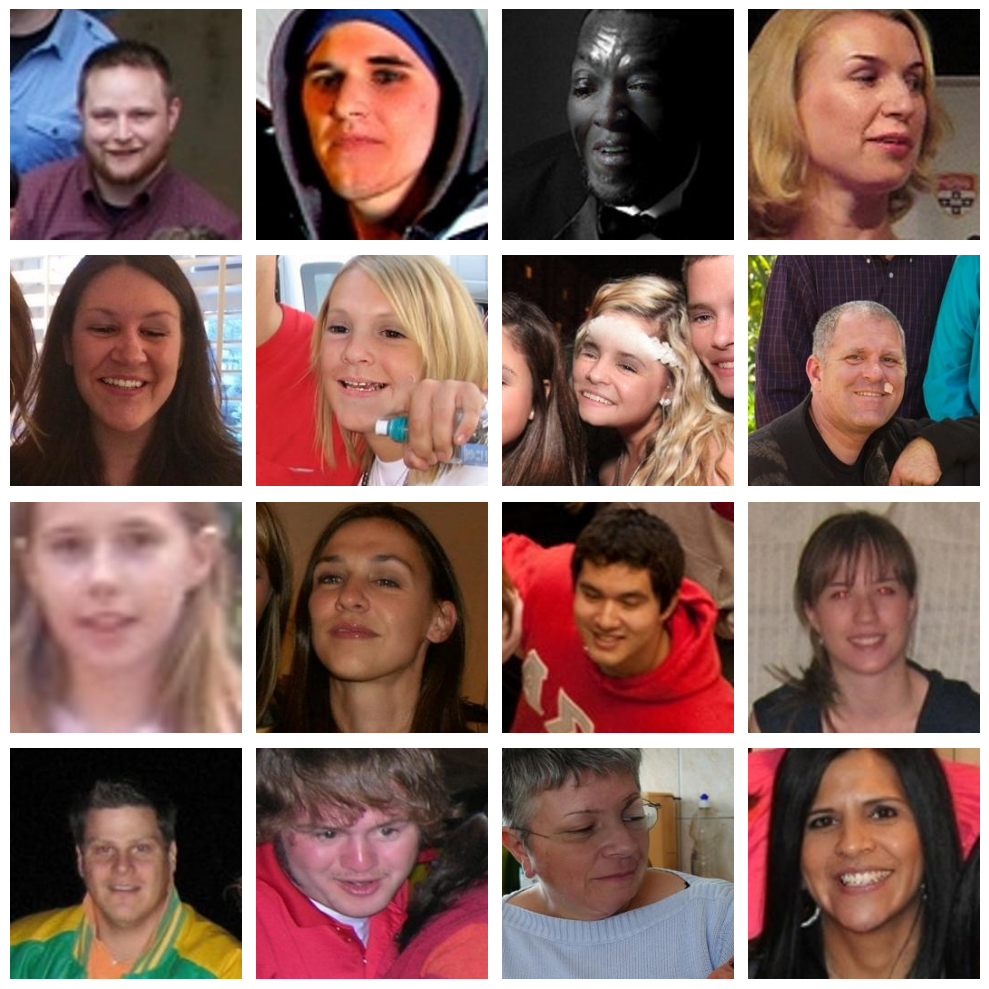

In [9]:

plot_random_images(train_dir)

In [10]:
# Set the path to your dataset
dataset_path = '/content/Dataset/Train/Train'

# Get the list of image filenames
image_filenames = os.listdir(dataset_path)
#print(image_filenames)

# Extract labels from filenames

labels = [1 if 'fake' in filename.lower() else 0 for filename in image_filenames]


# Create a DataFrame for easier handling
import pandas as pd
df = pd.DataFrame({'filename': image_filenames, 'label': labels})


In [11]:
df.head()

,filename,label
0,real_43.jpg,0
1,real_580.jpg,0
2,real_464.jpg,0
3,fake_244.jpg,1
4,real_758.jpg,0


In [12]:
df['label'].value_counts()

label
0    1207
1    1206
Name: count, dtype: int64

In [13]:
df.dtypes

filename    object
label        int64
dtype: object

In [14]:
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Define image dimensions and batch size
img_height, img_width = 150, 150
batch_size = 32

# Convert the label column to string
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)


In [15]:
# Create data generators for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=dataset_path,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)


Found 1929 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [17]:
validation_generator = validation_datagen.flow_from_dataframe(
    val_df,
    directory=dataset_path,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)


Found 483 validated image filenames belonging to 2 classes.


Model 1: CNN(4 Convolutional and Max Pooling Layers)

In [18]:
from tensorflow.keras import models, layers

# Build a modified CNN model
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

# Additional Convolutional Layer
model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

# Flatten the output before the dense layers
model2.add(layers.Flatten())

# Additional Dense Layer
model2.add(layers.Dense(256, activation='relu'))

# Dropout layer to reduce overfitting
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(1, activation='sigmoid'))


In [19]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [20]:
epochs = 5
history = model2.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/5
61/61 [==============================] - 109s 2s/step - loss: 0.6550 - accuracy: 0.6164 - val_loss: 0.4502 - val_accuracy: 0.8219
Epoch 2/5
61/61 [==============================] - 111s 2s/step - loss: 0.4327 - accuracy: 0.8123 - val_loss: 0.3774 - val_accuracy: 0.8385
Epoch 3/5
61/61 [==============================] - 111s 2s/step - loss: 0.4067 - accuracy: 0.8341 - val_loss: 0.3483 - val_accuracy: 0.8758
Epoch 4/5
61/61 [==============================] - 109s 2s/step - loss: 0.3723 - accuracy: 0.8419 - val_loss: 0.3377 - val_accuracy: 0.8778
Epoch 5/5
61/61 [==============================] - 105s 2s/step - loss: 0.3637 - accuracy: 0.8440 - val_loss: 0.3373 - val_accuracy: 0.8716


In [21]:
loss1, accuracy1 = model2.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy1 * 100:.2f}%")

16/16 [==============================] - 7s 443ms/step - loss: 0.3373 - accuracy: 0.8716
Validation accuracy: 87.16%


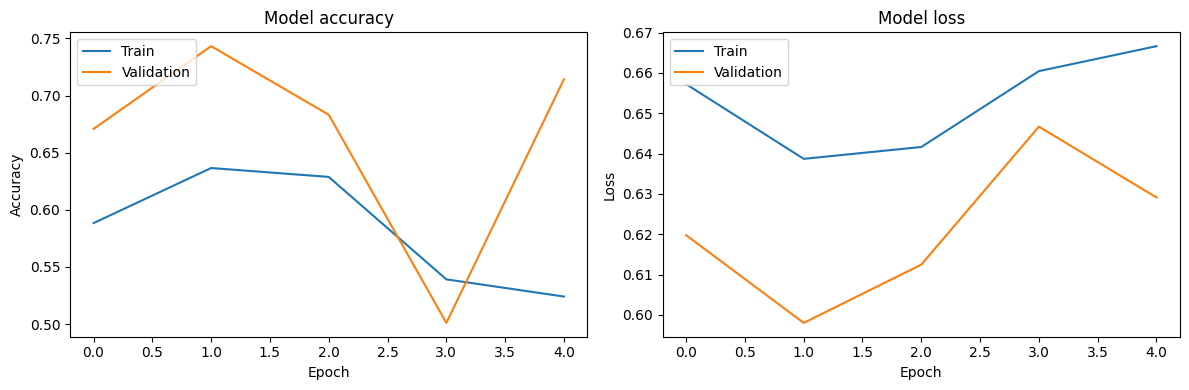

In [38]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



In [32]:
# Set the path to your test dataset
# Set the path to your test dataset
test_dataset_path = '/content/Dataset/Test'

# Create a data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Assuming it's a binary classification task
)


# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Found 612 images belonging to 1 classes.
20/20 [==============================] - 9s 451ms/step - loss: 0.4166 - accuracy: 0.8513
Test accuracy: 85.13%


In [33]:
# Set the path to your test dataset
test_dataset_path = '/content/Dataset/Test/Test'

# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model2.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class = 1 if prediction > 0.5 else 0

# Print the result
print(f"Predicted class: {predicted_class}")


1/1 [==============================] - 0s 38ms/step
Predicted class: 0


1/1 [==============================] - 0s 54ms/step


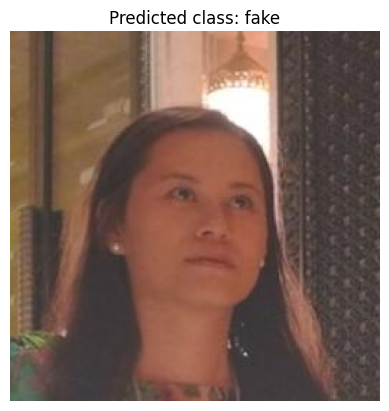

1/1 [==============================] - 0s 53ms/step


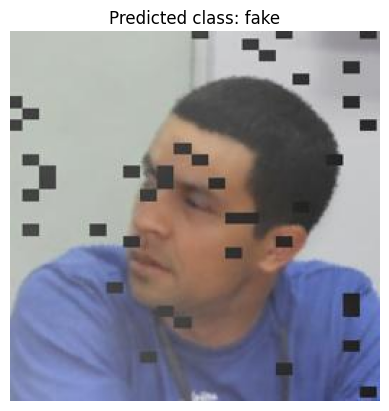

In [34]:
test_dataset_path = '/content/Dataset/Test/Test'

# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model2.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='real' if prediction > 0.5 else 'fake'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model2.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='real' if prediction > 0.5 else 'fake'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

Model 2: ResNet

In [39]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers

# Load the pre-trained ResNet50 model (excluding the top layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in resnet_model.layers:
    layer.trainable = False

# Build a new model on top of ResNet50
model3 = models.Sequential()

model3.add(resnet_model)

# Flatten the output before the dense layers
model3.add(layers.Flatten())

# Additional Dense Layer
model3.add(layers.Dense(256, activation='relu'))

# Dropout layer to reduce overfitting
model3.add(layers.Dropout(0.5))

model3.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [40]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [41]:
epochs = 5
history = model3.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/5
61/61 [==============================] - 210s 3s/step - loss: 1.1220 - accuracy: 0.5215 - val_loss: 0.6711 - val_accuracy: 0.7122
Epoch 2/5
61/61 [==============================] - 208s 3s/step - loss: 0.6864 - accuracy: 0.5495 - val_loss: 0.6762 - val_accuracy: 0.5135
Epoch 3/5
61/61 [==============================] - 205s 3s/step - loss: 0.6856 - accuracy: 0.5329 - val_loss: 0.6757 - val_accuracy: 0.5072
Epoch 4/5
61/61 [==============================] - 206s 3s/step - loss: 0.6774 - accuracy: 0.5713 - val_loss: 0.6552 - val_accuracy: 0.7350
Epoch 5/5
61/61 [==============================] - 207s 3s/step - loss: 0.6660 - accuracy: 0.5920 - val_loss: 0.6669 - val_accuracy: 0.6646


In [42]:
# Evaluate the model
loss2, accuracy2 = model3.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy2 * 100:.2f}%")

16/16 [==============================] - 37s 2s/step - loss: 0.6669 - accuracy: 0.6646
Validation accuracy: 66.46%


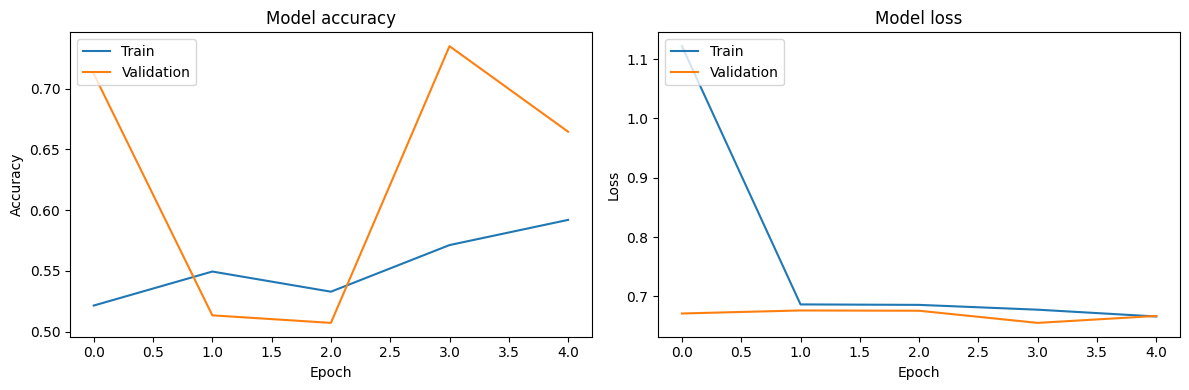

In [43]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [44]:
test_loss, test_accuracy = model3.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


20/20 [==============================] - 48s 2s/step - loss: 0.6123 - accuracy: 0.8121
Test accuracy: 81.21%


In [45]:
# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model3.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class = 1 if prediction > 0.5 else 0

# Print the result
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 1s 1s/step
Predicted class: 0


1/1 [==============================] - 0s 114ms/step


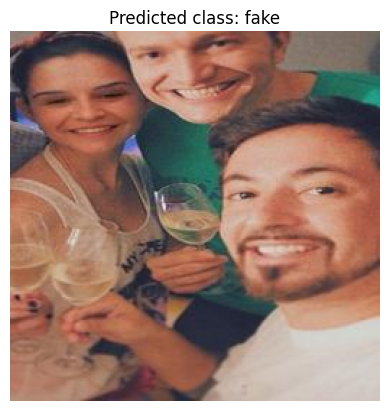

1/1 [==============================] - 0s 119ms/step


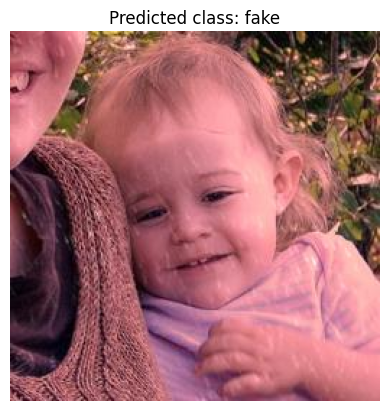

In [46]:
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model3.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='real' if prediction > 0.5 else 'fake'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model3.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='real' if prediction > 0.5 else 'fake'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

Model 3:VGG with Batch Normaliazation

In [47]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

# Load the pre-trained VGG16 model (excluding the top layer)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in vgg_model.layers:
    layer.trainable = False

# Build a new model on top of VGG16
model5 = models.Sequential()

model5.add(vgg_model)

# Flatten the output before the dense layers
model5.add(layers.Flatten())

# Additional Dense Layers with Batch Normalization
model5.add(layers.Dense(512, activation='relu'))
model5.add(layers.BatchNormalization())
model5.add(layers.Dropout(0.5))

model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.BatchNormalization())
model5.add(layers.Dropout(0.5))

# Output layer
model5.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [48]:
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [49]:
epochs = 5
history = model5.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)


Epoch 1/5
61/61 [==============================] - 549s 9s/step - loss: 0.4953 - accuracy: 0.7983 - val_loss: 0.6059 - val_accuracy: 0.7391
Epoch 2/5
61/61 [==============================] - 545s 9s/step - loss: 0.3549 - accuracy: 0.8611 - val_loss: 0.5070 - val_accuracy: 0.7909
Epoch 3/5
61/61 [==============================] - 542s 9s/step - loss: 0.2947 - accuracy: 0.8766 - val_loss: 0.3298 - val_accuracy: 0.8737
Epoch 4/5
61/61 [==============================] - 542s 9s/step - loss: 0.2688 - accuracy: 0.8828 - val_loss: 0.2496 - val_accuracy: 0.9048
Epoch 5/5
61/61 [==============================] - 542s 9s/step - loss: 0.2530 - accuracy: 0.8989 - val_loss: 0.2641 - val_accuracy: 0.9048


In [50]:
# Evaluate the model
loss3, accuracy3 = model5.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy3 * 100:.2f}%")

16/16 [==============================] - 118s 7s/step - loss: 0.2641 - accuracy: 0.9048
Validation accuracy: 90.48%


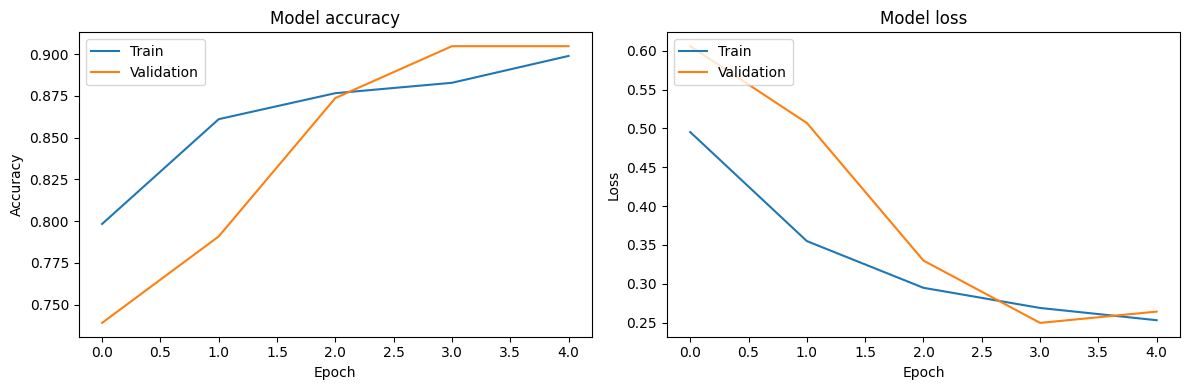

In [55]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model5.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

 5/20 [======>.......................] - ETA: 1:46 - loss: 1.2351 - accuracy: 0.6313

In [57]:
# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model5.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class = 1 if prediction > 0.5 else 0

# Print the result
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 0s 432ms/step
Predicted class: 0


1/1 [==============================] - 0s 241ms/step


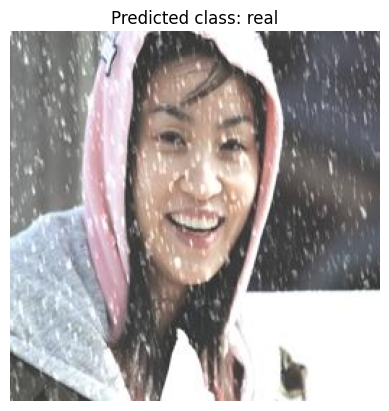

1/1 [==============================] - 0s 229ms/step


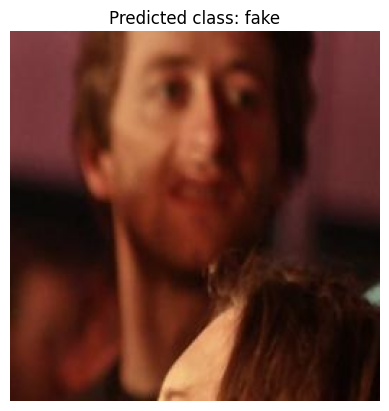

In [58]:
# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model5.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='real' if prediction > 0.5 else 'fake'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

# Get a random image from the test set
random_test_image_path = random.choice(test_generator.filepaths)

# Load and preprocess the image
img = image.load_img(random_test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values to be between 0 and 1

# Get the model's prediction
prediction = model5.predict(img_array)

# Map the prediction to a class (0 or 1)
predicted_class ='real' if prediction > 0.5 else 'fake'

# Display the image along with its predicted class
img = mpimg.imread(random_test_image_path)
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()


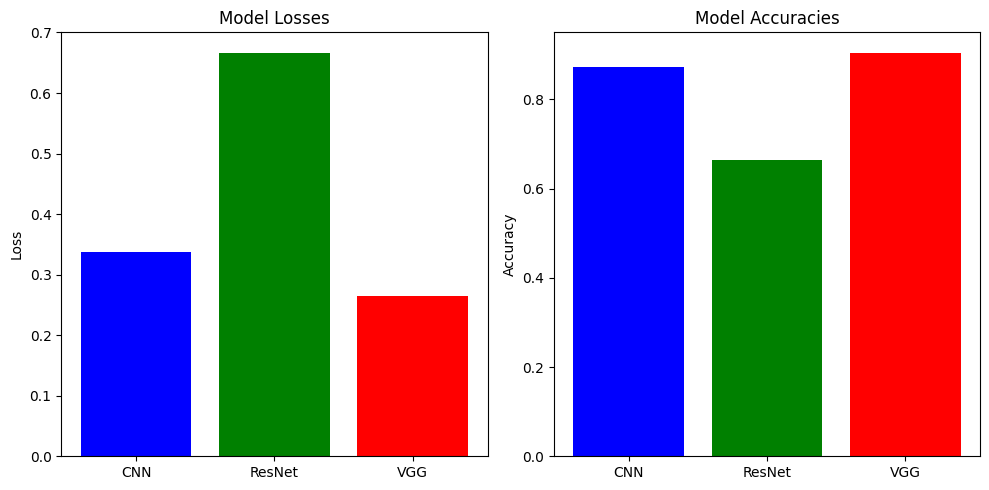

In [59]:
import matplotlib.pyplot as plt

models = ['CNN', 'ResNet', 'VGG']
losses = [loss1, loss2, loss3]
accuracies = [accuracy1, accuracy2, accuracy3]

# Plotting Losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, losses, color=['blue', 'green', 'red'])
plt.title('Model Losses')
plt.ylabel('Loss')

# Plotting Accuracies
plt.subplot(1, 2, 2)
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.title('Model Accuracies')
plt.ylabel('Accuracy')

# Show the plot
plt.tight_layout()
plt.show()